# A computational introduction to stochastic differential equations.

Lecture 6.

https://github.com/spdes/computational-sde-intro-lecture.

Kalman filtering and RTS smoothing on a motion model. See Lecture note 6.

In [1]:
import jax
import math
import jax.scipy
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Tuple
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
def discretise_lti_sde(A: jnp.ndarray, B: jnp.ndarray, dt: float) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """See the docstring in `lec5_linear_sde_mean_cov.ipynb`.
    """
    d = A.shape[0]

    F = jax.scipy.linalg.expm(A * dt)
    phi = jnp.vstack([jnp.hstack([A, B @ B.T]), jnp.hstack([jnp.zeros_like(A), -A.T])])
    AB = jax.scipy.linalg.expm(phi * dt) @ jnp.vstack([jnp.zeros_like(A), jnp.eye(d)])
    cov = AB[0:d, :] @ F.T
    return F, cov

In [3]:
dim_x = 4
dim_y = 2

A = jnp.array([[0., 1., 0., 0.],
               [0., 0., 0., 0.],
               [0., 0., 0., 1.],
               [0., 0., 0., 0.]])
B = jnp.array([[0., 0.],
               [1., 0.],
               [0., 0.],
               [0., 1.]])
H = jnp.array([[1., 0., 0., 0.],
               [0., 0., 1., 0.]])

Xi = jnp.eye(dim_y)

m0 = jnp.zeros((dim_x,))
V0 = jnp.eye(dim_x)

In [4]:
T = 100
dt = 0.1
ts = jnp.linspace(dt, dt * T, T)

F, Sigma = discretise_lti_sde(A, B, dt)
chol = jnp.linalg.cholesky(Sigma)

In [5]:
key = jax.random.PRNGKey(666)

x0 = m0 + jnp.linalg.cholesky(V0) @ jax.random.normal(key, (dim_x,))

key, _ = jax.random.split(key)


def scan_body(carry, elem):
    x = carry
    rnd_x, rnd_y = elem

    x = F @ x + chol @ rnd_x
    y = H @ x + rnd_y
    return x, (x, y)


rnds_x = jax.random.normal(key, (T, dim_x))
key, _ = jax.random.split(key)
rnds_y = jax.random.normal(key, (T, dim_y))

_, (xs, ys) = jax.lax.scan(scan_body, x0, (rnds_x, rnds_y))

key, _ = jax.random.split(key)

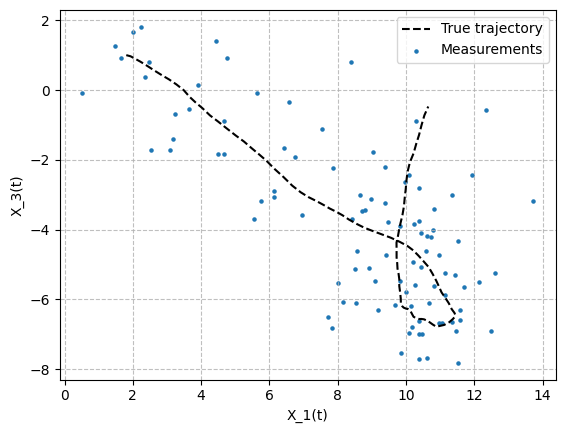

In [6]:
plt.plot(xs[:, 0], xs[:, 2], c='black', linestyle='--', label='True trajectory')
plt.scatter(ys[:, 0], ys[:, 1], s=5, label='Measurements')
plt.legend()
plt.xlabel('X_1(t)')
plt.ylabel('X_3(t)')
plt.grid(linestyle='--', alpha=0.8, which='both')

In [7]:
def _log_mvn_pdf(x, mu, chol) -> float:
    z = jax.lax.linalg.triangular_solve(chol, x - mu)
    return -0.5 * (jnp.dot(x - mu, z) + 2 * jnp.sum(jnp.log(math.sqrt(2 * math.pi) * jnp.diagonal(chol))))


def kf(ys):
    def scan_body(carry, elem):
        mf, Vf, n_ell = carry
        y = elem

        mp = F @ mf
        Vp = F @ Vf @ F.T + Sigma

        S = H @ Vp @ H.T + Xi
        chol = jax.lax.linalg.cholesky(S)
        K = Vp @ jax.lax.linalg.triangular_solve(chol, H, left_side=True, lower=True).T
        mf = mp + K @ (y - H @ mp)
        Vf = Vp - K @ S @ K.T
        n_ell -= _log_mvn_pdf(y, H @ mp, chol)

        return (mf, Vf, n_ell), (mf, Vf)

    return jax.lax.scan(scan_body, (m0, V0, 0.), ys)


def rts(mfs, Vfs):
    def scan_body(carry, elem):
        ms, Vs = carry
        mf, Vf = elem

        mp = F @ mf
        Vp = F @ Vf @ F.T + Sigma

        chol = jax.scipy.linalg.cho_factor(Vp)
        G = Vf @ jax.scipy.linalg.cho_solve(chol, F).T
        ms = mf + G @ (ms - mp)
        Vs = Vf + G @ (Vs - Vp) @ G.T

        return (ms, Vs), (ms, Vs)

    _, (mss, Vss) = jax.lax.scan(scan_body, (mfs[-1], Vfs[-1]), (mfs[:-1], Vfs[:-1]), reverse=True)
    return jnp.vstack([mss, mfs[-1]]), jnp.vstack([Vss, Vfs[-1, None]])

In [8]:
(_, _, n_ell), (mfs, Vfs) = kf(ys)
mss, Vss = rts(mfs, Vfs)

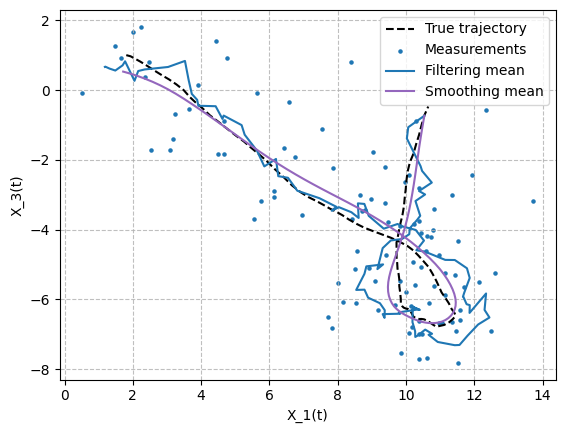

In [9]:
plt.plot(xs[:, 0], xs[:, 2], c='black', linestyle='--', label='True trajectory')
plt.scatter(ys[:, 0], ys[:, 1], s=5, label='Measurements')
plt.plot(mfs[:, 0], mfs[:, 2], c='tab:blue', label='Filtering mean')
plt.plot(mss[:, 0], mss[:, 2], c='tab:purple', label='Smoothing mean')

plt.legend()
plt.xlabel('X_1(t)')
plt.ylabel('X_3(t)')
plt.grid(linestyle='--', alpha=0.8, which='both')

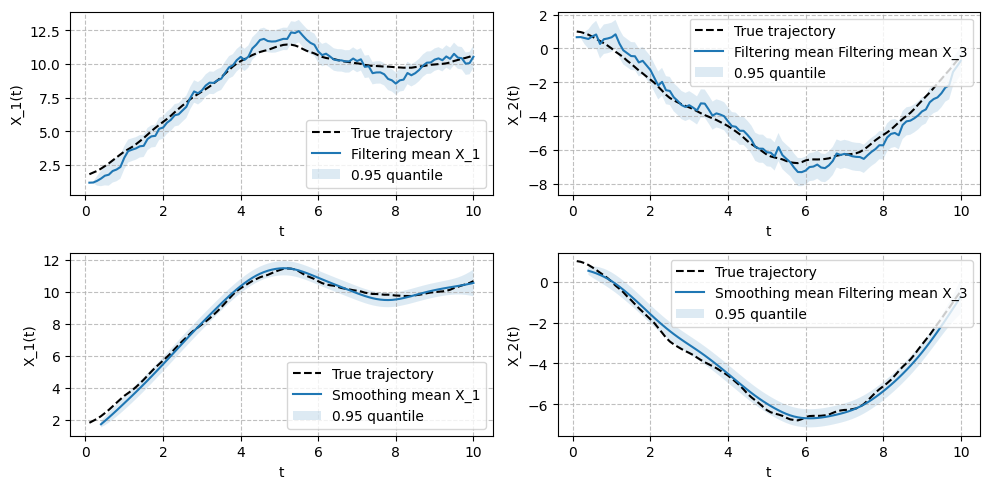

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes[0, 0].plot(ts, xs[:, 0], c='black', linestyle='--', label='True trajectory')
axes[0, 0].plot(ts, mfs[:, 0], c='tab:blue', label='Filtering mean X_1')
axes[0, 0].fill_between(ts,
                        mfs[:, 0] - 1.96 * jnp.sqrt(jnp.squeeze(Vfs[:, 0, 0])),
                        mfs[:, 0] + 1.96 * jnp.sqrt(jnp.squeeze(Vfs[:, 0, 0])),
                        color='tab:blue',
                        edgecolor='none',
                        alpha=0.15,
                        label='0.95 quantile')
axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel('X_1(t)')
axes[0, 0].grid(linestyle='--', alpha=0.8, which='both')
axes[0, 0].legend()

axes[0, 1].plot(ts, xs[:, 2], c='black', linestyle='--', label='True trajectory')
axes[0, 1].plot(ts, mfs[:, 2], c='tab:blue', label='Filtering mean Filtering mean X_3')
axes[0, 1].fill_between(ts,
                        mfs[:, 2] - 1.96 * jnp.sqrt(jnp.squeeze(Vfs[:, 2, 2])),
                        mfs[:, 2] + 1.96 * jnp.sqrt(jnp.squeeze(Vfs[:, 2, 2])),
                        color='tab:blue',
                        edgecolor='none',
                        alpha=0.15,
                        label='0.95 quantile')
axes[0, 1].set_xlabel('t')
axes[0, 1].set_ylabel('X_2(t)')
axes[0, 1].grid(linestyle='--', alpha=0.8, which='both')
axes[0, 1].legend()

axes[1, 0].plot(ts, xs[:, 0], c='black', linestyle='--', label='True trajectory')
axes[1, 0].plot(ts, mss[:, 0], c='tab:blue', label='Smoothing mean X_1')
axes[1, 0].fill_between(ts,
                        mss[:, 0] - 1.96 * jnp.sqrt(jnp.squeeze(Vss[:, 0, 0])),
                        mss[:, 0] + 1.96 * jnp.sqrt(jnp.squeeze(Vss[:, 0, 0])),
                        color='tab:blue',
                        edgecolor='none',
                        alpha=0.15,
                        label='0.95 quantile')
axes[1, 0].set_xlabel('t')
axes[1, 0].set_ylabel('X_1(t)')
axes[1, 0].grid(linestyle='--', alpha=0.8, which='both')
axes[1, 0].legend()

axes[1, 1].plot(ts, xs[:, 2], c='black', linestyle='--', label='True trajectory')
axes[1, 1].plot(ts, mss[:, 2], c='tab:blue', label='Smoothing mean Filtering mean X_3')
axes[1, 1].fill_between(ts,
                        mss[:, 2] - 1.96 * jnp.sqrt(jnp.squeeze(Vss[:, 2, 2])),
                        mss[:, 2] + 1.96 * jnp.sqrt(jnp.squeeze(Vss[:, 2, 2])),
                        color='tab:blue',
                        edgecolor='none',
                        alpha=0.15,
                        label='0.95 quantile')
axes[1, 1].set_xlabel('t')
axes[1, 1].set_ylabel('X_2(t)')
axes[1, 1].grid(linestyle='--', alpha=0.8, which='both')
axes[1, 1].legend()

plt.tight_layout()

In [10]:
n_ell

DeviceArray(319.70163201, dtype=float64)